In [2]:
from opensimplex import OpenSimplex

In [11]:

import random, math

buckets = 20
samples = 1000000
rng_range = 100000
char_width = 50

os = OpenSimplex(0)
histogram2 = [0] * (buckets)
histogram3 = [0] * (buckets)
histogram4 = [0] * (buckets)

for i in range(samples):
	x = random.uniform(-rng_range, rng_range)
	y = random.uniform(-rng_range, rng_range)
	z = random.uniform(-rng_range, rng_range)
	w = random.uniform(-rng_range, rng_range)
	v2 = os.noise2(x, y)
	b2 = round((v2+1) / 2 * (buckets-1))
	histogram2[b2] += 1
	v3 = os.noise3(x, y, z)
	b3 = round((v3+1) / 2 * (buckets-1))
	histogram3[b3] += 1
	v4 = os.noise4(x, y, z, w)
	b4 = round((v4+1) / 2 * (buckets-1))
	histogram4[b4] += 1

def print_histogram(histogram):
	biggest = max(histogram)
	for i in range(buckets):
		v = histogram[i]
		n = ((i+0.5) / buckets) * 2 - 1
		w = char_width * v / biggest
		c = ''.join(['*'] * round(w))
		print(f'{n: .2f} {c}')



In [6]:
print("\t2D Noise")
print_histogram(histogram2)


	2D Noise
-0.95 
-0.85 
-0.75 *****
-0.65 ***************
-0.55 **************************
-0.45 *****************************************
-0.35 **************************************************
-0.25 **************************************************
-0.15 *************************************************
-0.05 *************************************************
 0.05 *************************************************
 0.15 *************************************************
 0.25 *************************************************
 0.35 *************************************************
 0.45 ****************************************
 0.55 **************************
 0.65 ***************
 0.75 *****
 0.85 
 0.95 


In [8]:
print("\t3D Noise")
print_histogram(histogram3)


	3D Noise
-0.95 
-0.85 
-0.75 *
-0.65 ****
-0.55 *************
-0.45 **************************
-0.35 ************************************
-0.25 *******************************************
-0.15 ***********************************************
-0.05 **************************************************
 0.05 **************************************************
 0.15 ************************************************
 0.25 *******************************************
 0.35 ************************************
 0.45 **************************
 0.55 *************
 0.65 ****
 0.75 *
 0.85 
 0.95 


In [9]:
print("\t4D Noise")
print_histogram(histogram4)

	4D Noise
-0.95 
-0.85 
-0.75 
-0.65 
-0.55 ***
-0.45 **********
-0.35 *********************
-0.25 *********************************
-0.15 ********************************************
-0.05 **************************************************
 0.05 **************************************************
 0.15 *******************************************
 0.25 *********************************
 0.35 *********************
 0.45 **********
 0.55 ***
 0.65 *
 0.75 
 0.85 
 0.95 


In [16]:
# Copyright (c) 2008, Casey Duncan (casey dot duncan at gmail dot com)
# see LICENSE.txt for details

"""Perlin noise -- pure python implementation"""

__version__ = '$Id: perlin.py 521 2008-12-15 03:03:52Z casey.duncan $'

from math import floor, fmod, sqrt
from random import randint

# 3D Gradient vectors
_GRAD3 = ((1,1,0),(-1,1,0),(1,-1,0),(-1,-1,0), 
	(1,0,1),(-1,0,1),(1,0,-1),(-1,0,-1), 
	(0,1,1),(0,-1,1),(0,1,-1),(0,-1,-1),
	(1,1,0),(0,-1,1),(-1,1,0),(0,-1,-1),
) 

# 4D Gradient vectors
_GRAD4 = ((0,1,1,1), (0,1,1,-1), (0,1,-1,1), (0,1,-1,-1), 
	(0,-1,1,1), (0,-1,1,-1), (0,-1,-1,1), (0,-1,-1,-1), 
	(1,0,1,1), (1,0,1,-1), (1,0,-1,1), (1,0,-1,-1), 
	(-1,0,1,1), (-1,0,1,-1), (-1,0,-1,1), (-1,0,-1,-1), 
	(1,1,0,1), (1,1,0,-1), (1,-1,0,1), (1,-1,0,-1), 
	(-1,1,0,1), (-1,1,0,-1), (-1,-1,0,1), (-1,-1,0,-1), 
	(1,1,1,0), (1,1,-1,0), (1,-1,1,0), (1,-1,-1,0), 
	(-1,1,1,0), (-1,1,-1,0), (-1,-1,1,0), (-1,-1,-1,0))

# A lookup table to traverse the simplex around a given point in 4D. 
# Details can be found where this table is used, in the 4D noise method. 
_SIMPLEX = (
	(0,1,2,3),(0,1,3,2),(0,0,0,0),(0,2,3,1),(0,0,0,0),(0,0,0,0),(0,0,0,0),(1,2,3,0), 
	(0,2,1,3),(0,0,0,0),(0,3,1,2),(0,3,2,1),(0,0,0,0),(0,0,0,0),(0,0,0,0),(1,3,2,0), 
	(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0), 
	(1,2,0,3),(0,0,0,0),(1,3,0,2),(0,0,0,0),(0,0,0,0),(0,0,0,0),(2,3,0,1),(2,3,1,0), 
	(1,0,2,3),(1,0,3,2),(0,0,0,0),(0,0,0,0),(0,0,0,0),(2,0,3,1),(0,0,0,0),(2,1,3,0), 
	(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0), 
	(2,0,1,3),(0,0,0,0),(0,0,0,0),(0,0,0,0),(3,0,1,2),(3,0,2,1),(0,0,0,0),(3,1,2,0), 
	(2,1,0,3),(0,0,0,0),(0,0,0,0),(0,0,0,0),(3,1,0,2),(0,0,0,0),(3,2,0,1),(3,2,1,0))

# Simplex skew constants
_F2 = 0.5 * (sqrt(3.0) - 1.0)
_G2 = (3.0 - sqrt(3.0)) / 6.0
_F3 = 1.0 / 3.0
_G3 = 1.0 / 6.0


class BaseNoise:
	"""Noise abstract base class"""

	permutation = (151,160,137,91,90,15, 
		131,13,201,95,96,53,194,233,7,225,140,36,103,30,69,142,8,99,37,240,21,10,23, 
		190,6,148,247,120,234,75,0,26,197,62,94,252,219,203,117,35,11,32,57,177,33, 
		88,237,149,56,87,174,20,125,136,171,168,68,175,74,165,71,134,139,48,27,166, 
		77,146,158,231,83,111,229,122,60,211,133,230,220,105,92,41,55,46,245,40,244, 
		102,143,54,65,25,63,161,1,216,80,73,209,76,132,187,208,89,18,169,200,196, 
		135,130,116,188,159,86,164,100,109,198,173,186,3,64,52,217,226,250,124,123, 
		5,202,38,147,118,126,255,82,85,212,207,206,59,227,47,16,58,17,182,189,28,42, 
		223,183,170,213,119,248,152,2,44,154,163,70,221,153,101,155,167,43,172,9, 
		129,22,39,253,9,98,108,110,79,113,224,232,178,185,112,104,218,246,97,228, 
		251,34,242,193,238,210,144,12,191,179,162,241, 81,51,145,235,249,14,239,107, 
		49,192,214,31,181,199,106,157,184,84,204,176,115,121,50,45,127,4,150,254, 
		138,236,205,93,222,114,67,29,24,72,243,141,128,195,78,66,215,61,156,180)

	period = len(permutation)

	# Double permutation array so we don't need to wrap
	permutation = permutation * 2

	randint_function = randint

	def __init__(self, period=None, permutation_table=None, randint_function=None):
		"""Initialize the noise generator. With no arguments, the default
		period and permutation table are used (256). The default permutation
		table generates the exact same noise pattern each time.
		
		An integer period can be specified, to generate a random permutation
		table with period elements. The period determines the (integer)
		interval that the noise repeats, which is useful for creating tiled
		textures.  period should be a power-of-two, though this is not
		enforced. Note that the speed of the noise algorithm is indpendent of
		the period size, though larger periods mean a larger table, which
		consume more memory.
		A permutation table consisting of an iterable sequence of whole
		numbers can be specified directly. This should have a power-of-two
		length. Typical permutation tables are a sequnce of unique integers in
		the range [0,period) in random order, though other arrangements could
		prove useful, they will not be "pure" simplex noise. The largest
		element in the sequence must be no larger than period-1.
		period and permutation_table may not be specified together.
		A substitute for the method random.randint(a, b) can be chosen. The
		method must take two integer parameters a and b and return an integer N
		such that a <= N <= b.
		"""
		if randint_function is not None:  # do this before calling randomize()
			if not hasattr(randint_function, '__call__'):
				raise TypeError(
					'randint_function has to be a function')
			self.randint_function = randint_function
			if period is None:
				period = self.period  # enforce actually calling randomize()
		if period is not None and permutation_table is not None:
			raise ValueError(
				'Can specify either period or permutation_table, not both')
		if period is not None:
			self.randomize(period)
		elif permutation_table is not None:
			self.permutation = tuple(permutation_table) * 2
			self.period = len(permutation_table)

	def randomize(self, period=None):
		"""Randomize the permutation table used by the noise functions. This
		makes them generate a different noise pattern for the same inputs.
		"""
		if period is not None:
			self.period = period
		perm = list(range(self.period))
		perm_right = self.period - 1
		for i in list(perm):
			j = self.randint_function(0, perm_right)
			perm[i], perm[j] = perm[j], perm[i]
		self.permutation = tuple(perm) * 2


class SimplexNoise(BaseNoise):
	"""Perlin simplex noise generator
	Adapted from Stefan Gustavson's Java implementation described here:
	http://staffwww.itn.liu.se/~stegu/simplexnoise/simplexnoise.pdf
	To summarize:
	"In 2001, Ken Perlin presented 'simplex noise', a replacement for his classic
	noise algorithm.  Classic 'Perlin noise' won him an academy award and has
	become an ubiquitous procedural primitive for computer graphics over the
	years, but in hindsight it has quite a few limitations.  Ken Perlin himself
	designed simplex noise specifically to overcome those limitations, and he
	spent a lot of good thinking on it. Therefore, it is a better idea than his
	original algorithm. A few of the more prominent advantages are: 
	* Simplex noise has a lower computational complexity and requires fewer
	  multiplications. 
	* Simplex noise scales to higher dimensions (4D, 5D and up) with much less
	  computational cost, the complexity is O(N) for N dimensions instead of 
	  the O(2^N) of classic Noise. 
	* Simplex noise has no noticeable directional artifacts.  Simplex noise has 
	  a well-defined and continuous gradient everywhere that can be computed 
	  quite cheaply. 
	* Simplex noise is easy to implement in hardware."
	"""

	def noise2(self, x, y):
		"""2D Perlin simplex noise. 
		
		Return a floating point value from -1 to 1 for the given x, y coordinate. 
		The same value is always returned for a given x, y pair unless the
		permutation table changes (see randomize above). 
		"""
		# Skew input space to determine which simplex (triangle) we are in
		s = (x + y) * _F2
		i = floor(x + s)
		j = floor(y + s)
		t = (i + j) * _G2
		x0 = x - (i - t) # "Unskewed" distances from cell origin
		y0 = y - (j - t)

		if x0 > y0:
			i1 = 1; j1 = 0 # Lower triangle, XY order: (0,0)->(1,0)->(1,1)
		else:
			i1 = 0; j1 = 1 # Upper triangle, YX order: (0,0)->(0,1)->(1,1)
		
		x1 = x0 - i1 + _G2 # Offsets for middle corner in (x,y) unskewed coords
		y1 = y0 - j1 + _G2
		x2 = x0 + _G2 * 2.0 - 1.0 # Offsets for last corner in (x,y) unskewed coords
		y2 = y0 + _G2 * 2.0 - 1.0

		# Determine hashed gradient indices of the three simplex corners
		perm = self.permutation
		ii = int(i) % self.period
		jj = int(j) % self.period
		gi0 = perm[ii + perm[jj]] % 12
		gi1 = perm[ii + i1 + perm[jj + j1]] % 12
		gi2 = perm[ii + 1 + perm[jj + 1]] % 12

		# Calculate the contribution from the three corners
		tt = 0.5 - x0**2 - y0**2
		if tt > 0:
			g = _GRAD3[gi0]
			noise = tt**4 * (g[0] * x0 + g[1] * y0)
		else:
			noise = 0.0
		
		tt = 0.5 - x1**2 - y1**2
		if tt > 0:
			g = _GRAD3[gi1]
			noise += tt**4 * (g[0] * x1 + g[1] * y1)
		
		tt = 0.5 - x2**2 - y2**2
		if tt > 0:
			g = _GRAD3[gi2]
			noise += tt**4 * (g[0] * x2 + g[1] * y2)

		return noise * 70.0 # scale noise to [-1, 1]

	def noise3(self, x, y, z):
		"""3D Perlin simplex noise. 
		
		Return a floating point value from -1 to 1 for the given x, y, z coordinate. 
		The same value is always returned for a given x, y, z pair unless the
		permutation table changes (see randomize above).
		"""
		# Skew the input space to determine which simplex cell we're in
		s = (x + y + z) * _F3
		i = floor(x + s)
		j = floor(y + s)
		k = floor(z + s)
		t = (i + j + k) * _G3
		x0 = x - (i - t) # "Unskewed" distances from cell origin
		y0 = y - (j - t)
		z0 = z - (k - t)

		# For the 3D case, the simplex shape is a slightly irregular tetrahedron. 
		# Determine which simplex we are in. 
		if x0 >= y0:
			if y0 >= z0:
				i1 = 1; j1 = 0; k1 = 0
				i2 = 1; j2 = 1; k2 = 0
			elif x0 >= z0:
				i1 = 1; j1 = 0; k1 = 0
				i2 = 1; j2 = 0; k2 = 1
			else:
				i1 = 0; j1 = 0; k1 = 1
				i2 = 1; j2 = 0; k2 = 1
		else: # x0 < y0
			if y0 < z0:
				i1 = 0; j1 = 0; k1 = 1
				i2 = 0; j2 = 1; k2 = 1
			elif x0 < z0:
				i1 = 0; j1 = 1; k1 = 0
				i2 = 0; j2 = 1; k2 = 1
			else:
				i1 = 0; j1 = 1; k1 = 0
				i2 = 1; j2 = 1; k2 = 0
		
		# Offsets for remaining corners
		x1 = x0 - i1 + _G3
		y1 = y0 - j1 + _G3
		z1 = z0 - k1 + _G3
		x2 = x0 - i2 + 2.0 * _G3
		y2 = y0 - j2 + 2.0 * _G3
		z2 = z0 - k2 + 2.0 * _G3
		x3 = x0 - 1.0 + 3.0 * _G3
		y3 = y0 - 1.0 + 3.0 * _G3
		z3 = z0 - 1.0 + 3.0 * _G3

		# Calculate the hashed gradient indices of the four simplex corners
		perm = self.permutation
		ii = int(i) % self.period
		jj = int(j) % self.period
		kk = int(k) % self.period
		gi0 = perm[ii + perm[jj + perm[kk]]] % 12
		gi1 = perm[ii + i1 + perm[jj + j1 + perm[kk + k1]]] % 12
		gi2 = perm[ii + i2 + perm[jj + j2 + perm[kk + k2]]] % 12
		gi3 = perm[ii + 1 + perm[jj + 1 + perm[kk + 1]]] % 12

		# Calculate the contribution from the four corners
		noise = 0.0
		tt = 0.6 - x0**2 - y0**2 - z0**2
		if tt > 0:
			g = _GRAD3[gi0]
			noise = tt**4 * (g[0] * x0 + g[1] * y0 + g[2] * z0)
		else:
			noise = 0.0
		
		tt = 0.6 - x1**2 - y1**2 - z1**2
		if tt > 0:
			g = _GRAD3[gi1]
			noise += tt**4 * (g[0] * x1 + g[1] * y1 + g[2] * z1)
		
		tt = 0.6 - x2**2 - y2**2 - z2**2
		if tt > 0:
			g = _GRAD3[gi2]
			noise += tt**4 * (g[0] * x2 + g[1] * y2 + g[2] * z2)
		
		tt = 0.6 - x3**2 - y3**2 - z3**2
		if tt > 0:
			g = _GRAD3[gi3]
			noise += tt**4 * (g[0] * x3 + g[1] * y3 + g[2] * z3)
		
		return noise * 32.0


def lerp(t, a, b):
	return a + t * (b - a)

def grad3(hash, x, y, z):
	g = _GRAD3[hash % 16]
	return x*g[0] + y*g[1] + z*g[2]


class TileableNoise(BaseNoise):
	"""Tileable implemention of Perlin "improved" noise. This
	is based on the reference implementation published here:
	
	http://mrl.nyu.edu/~perlin/noise/
	"""

	def noise3(self, x, y, z, repeat, base=0.0):
		"""Tileable 3D noise.
		
		repeat specifies the integer interval in each dimension 
		when the noise pattern repeats.
		
		base allows a different texture to be generated for
		the same repeat interval.
		"""
		i = int(fmod(floor(x), repeat))
		j = int(fmod(floor(y), repeat))
		k = int(fmod(floor(z), repeat))
		ii = (i + 1) % repeat
		jj = (j + 1) % repeat
		kk = (k + 1) % repeat
		if base:
			i += base; j += base; k += base
			ii += base; jj += base; kk += base

		x -= floor(x); y -= floor(y); z -= floor(z)
		fx = x**3 * (x * (x * 6 - 15) + 10)
		fy = y**3 * (y * (y * 6 - 15) + 10)
		fz = z**3 * (z * (z * 6 - 15) + 10)

		perm = self.permutation
		A = perm[i]
		AA = perm[A + j]
		AB = perm[A + jj]
		B = perm[ii]
		BA = perm[B + j]
		BB = perm[B + jj]
		
		return lerp(fz, lerp(fy, lerp(fx, grad3(perm[AA + k], x, y, z),
										  grad3(perm[BA + k], x - 1, y, z)),
								 lerp(fx, grad3(perm[AB + k], x, y - 1, z),
										  grad3(perm[BB + k], x - 1, y - 1, z))),
						lerp(fy, lerp(fx, grad3(perm[AA + kk], x, y, z - 1),
										  grad3(perm[BA + kk], x - 1, y, z - 1)),
								 lerp(fx, grad3(perm[AB + kk], x, y - 1, z - 1),
										  grad3(perm[BB + kk], x - 1, y - 1, z - 1))))


In [15]:
import noise
import numpy as np
import matplotlib.pyplot as plt

# Define the size of the noise map
width = 200
height = 200

# Generate the Perlin noise map
scale = 50.0
octaves = 6
persistence = 0.5
lacunarity = 2.0
seed = 0
perlin_map = np.zeros((width, height))
for i in range(width):
    for j in range(height):
        perlin_map[i][j] = noise.pnoise2(i/scale, j/scale, octaves=octaves, persistence=persistence, lacunarity=lacunarity, repeatx=width, repeaty=height, base=seed)

# Plot the Perlin noise map
plt.imshow(perlin_map, cmap='gray')
plt.show()


ModuleNotFoundError: No module named 'noise'

In [19]:
import random

import matplotlib.pyplot as plt
import numpy as np

import evaluation
from helpers import *
from simplex import Simplex_CLASS
import os
def generate_simplex_noise(
        Simplex_instance, x, t, random_param=False, octave=6, persistence=0.8, frequency=64,
        in_channels=4
        ):
    noise = torch.empty(x.shape).to(x.device)
#     print("x", x.shape)
#     print("noise", noise.shape)
    for i in range(in_channels):
        Simplex_instance.newSeed()
        if random_param:
            param = random.choice(
                    [(2, 0.6, 16), (6, 0.6, 32), (7, 0.7, 32), (10, 0.8, 64), (5, 0.8, 16), (4, 0.6, 16), (1, 0.6, 64),
                     (7, 0.8, 128), (6, 0.9, 64), (2, 0.85, 128), (2, 0.85, 64), (2, 0.85, 32), (2, 0.85, 16),
                     (2, 0.85, 8),
                     (2, 0.85, 4), (2, 0.85, 2), (1, 0.85, 128), (1, 0.85, 64), (1, 0.85, 32), (1, 0.85, 16),
                     (1, 0.85, 8),
                     (1, 0.85, 4), (1, 0.85, 2), ]
                    )
            # 2D octaves seem to introduce directional artifacts in the top left
            noise[:, i, ...] = torch.unsqueeze(
                    torch.from_numpy(
                            # Simplex_instance.rand_2d_octaves(
                            #         x.shape[-2:], param[0], param[1],
                            #         param[2]
                            #         )
                            Simplex_instance.rand_3d_fixed_T_octaves(
                                    x.shape[-2:], t.detach().cpu().numpy(), param[0], param[1],
                                    param[2]
                                    )
                            ).to(x.device), 0
                    ).repeat(x.shape[0], 1, 1, 1)
#         print(f"i and in_channels {i} / {in_channels}")
#         print("noise shape", noise.shape)
#         print("t shape", t.shape)
        noise[:, i, ...] = torch.unsqueeze(
                torch.from_numpy(
                        # Simplex_instance.rand_2d_octaves(
                        #         x.shape[-2:], octave,
                        #         persistence, frequency
                        #         )
                        Simplex_instance.rand_3d_fixed_T_octaves(
                                x.shape[-2:], t.detach().cpu().numpy(), octave,
                                persistence, frequency
                                )
                        ).to(x.device), 0
                ).repeat(x.shape[0], 1, 1, 1)
    return noise

In [23]:
Simplex_instance = Simplex_CLASS()

In [25]:
simplex

In [27]:
x = torch.rand(1, 3, 448, 448)

In [51]:
t = torch.tensor([1])

In [197]:
octave=2
persistence=0.2
frequency=2

In [198]:
z = torch.unsqueeze(
                torch.from_numpy(
                        Simplex_instance.rand_3d_fixed_T_octaves(
                                x.shape[-2:], t.detach().cpu().numpy(), octave,
                                persistence, frequency
                                )
                        ).to(x.device), 0
                )
z1 = torch.unsqueeze(
                torch.from_numpy(
                        Simplex_instance.rand_3d_fixed_T_octaves(
                                x.shape[-2:], t.detach().cpu().numpy(), octave,
                                persistence, frequency
                                )
                        ).to(x.device), 0
                )

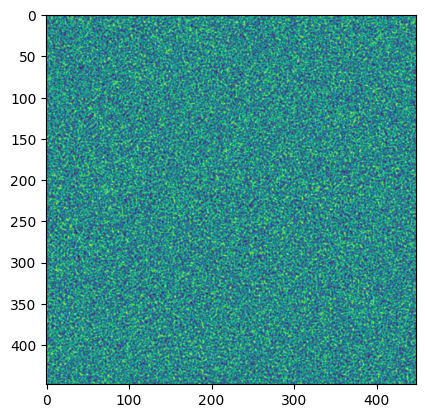

In [200]:
plt.imshow(z[0][0])

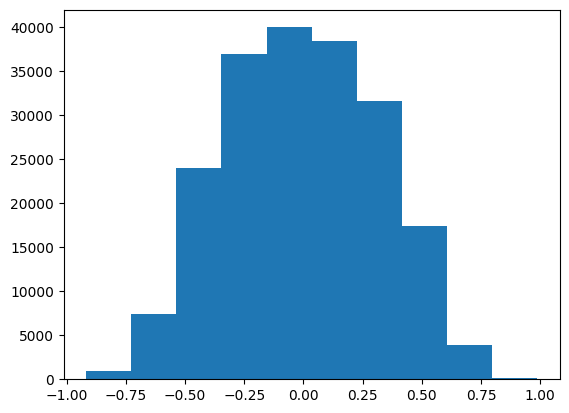

In [201]:
plt.hist(z[0][0].ravel())
plt.show()

In [202]:
import scipy.stats as stats

# Perform the Shapiro-Wilk test
stat, p = stats.shapiro(z[0][0])

# Print the p-value
print("p-value:", p)

p-value: 0.0


In [181]:
import scipy.stats as stats
x = z[0][0]
# Define the mean and standard deviation of the distribution
mu = torch.mean(x)
sigma = torch.std(x)

# Calculate the Gaussian score for a value of x

gaussian_score = stats.norm.pdf(x, mu, sigma)

print("The Gaussian score for x =", x, "is", gaussian_score)

The Gaussian score for x = tensor([[-2.7146e-02, -1.2540e-05,  2.6872e-02,  ...,  2.0160e-02,
          1.9563e-03, -1.7957e-02],
        [-1.0165e-01, -7.4452e-02, -4.7312e-02,  ...,  2.3618e-02,
          3.8570e-03, -1.7616e-02],
        [-1.7538e-01, -1.4823e-01, -1.2091e-01,  ...,  2.6264e-02,
          4.7993e-03, -1.8359e-02],
        ...,
        [-7.5669e-01, -7.3019e-01, -7.0259e-01,  ...,  1.3771e-01,
          1.5141e-01,  1.6463e-01],
        [-7.4600e-01, -7.2024e-01, -6.9344e-01,  ...,  1.5682e-01,
          1.7102e-01,  1.8473e-01],
        [-7.3564e-01, -7.1075e-01, -6.8490e-01,  ...,  1.7571e-01,
          1.9033e-01,  2.0445e-01]], dtype=torch.float64) is [[0.90945994 0.89934264 0.88600508 ... 0.88963649 0.89847617 0.90641776]
 [0.9191587  0.91874003 0.91473298 ... 0.88779056 0.89762296 0.90629736]
 [0.90228531 0.91151969 0.91727191 ... 0.88634246 0.89719388 0.90655941]
 ...
 [0.28360578 0.3108802  0.34071764 ... 0.79997449 0.78636859 0.77273293]
 [0.29444097 0.32147

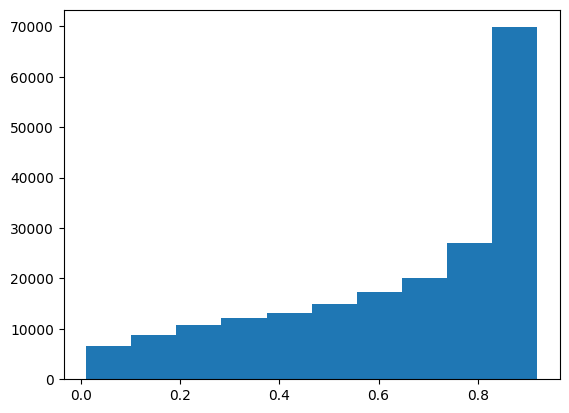

In [182]:
plt.hist(gaussian_score.ravel())
plt.show()

In [177]:
gaussian_score

(448, 448)

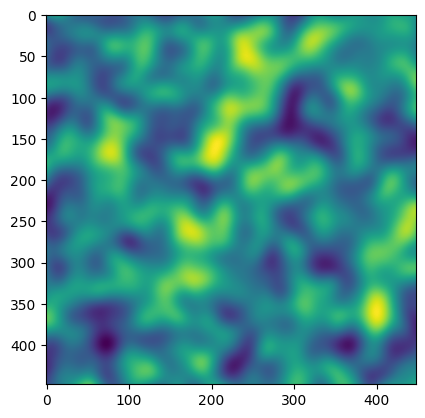

In [172]:
plt.imshow(z1[0][0])

In [85]:
from numba import njit, prange

In [61]:
def _init(seed=3):
    # Have to zero fill so we can properly loop over it later
    perm = np.zeros(256, dtype=np.int64)
    perm_grad_index3 = np.zeros(256, dtype=np.int64)
    source = np.arange(256)
    # Generates a proper permutation (i.e. doesn't merely perform N
    # successive pair swaps on a base array)
    seed = overflow(seed * 6364136223846793005 + 1442695040888963407)
    seed = overflow(seed * 6364136223846793005 + 1442695040888963407)
    seed = overflow(seed * 6364136223846793005 + 1442695040888963407)
    for i in range(255, -1, -1):
        seed = overflow(seed * 6364136223846793005 + 1442695040888963407)
        r = int((seed + 31) % (i + 1))
        if r < 0:
            r += i + 1
        perm[i] = source[r]
        perm_grad_index3[i] = int((perm[i] % (len(GRADIENTS3) / 3)) * 3)
        source[r] = source[i]
    return perm, perm_grad_index3

In [63]:
# _perm, _perm_grad_index3 = _init(100)

In [222]:
x = torch.rand(1, 4, 224, 224)

In [223]:
x = x.norm(dim = 1, keepdim=True, p = 1)
x.shape

torch.Size([1, 1, 224, 224])

In [224]:
abs_x = x.abs()

# Compute the sum of the absolute values of the tensor
sum_abs_x = abs_x.sum(dim =1, keepdim =True)

In [227]:
sum_abs_x

tensor([[[[1.8176, 1.2822, 1.9790,  ..., 2.4591, 1.4737, 1.5671],
          [2.8655, 1.5921, 2.4338,  ..., 2.3521, 1.2844, 2.2242],
          [1.8036, 2.6720, 1.5913,  ..., 1.4883, 2.4402, 3.3461],
          ...,
          [2.0726, 1.8182, 1.6057,  ..., 2.8744, 2.2385, 1.4098],
          [2.5670, 3.0316, 3.0576,  ..., 1.1497, 0.5964, 1.5759],
          [2.2494, 1.3833, 1.7758,  ..., 1.3531, 2.4812, 1.6300]]]])

In [226]:
sum_abs_x.to(torch.uint8)

tensor([[[[1, 1, 1,  ..., 2, 1, 1],
          [2, 1, 2,  ..., 2, 1, 2],
          [1, 2, 1,  ..., 1, 2, 3],
          ...,
          [2, 1, 1,  ..., 2, 2, 1],
          [2, 3, 3,  ..., 1, 0, 1],
          [2, 1, 1,  ..., 1, 2, 1]]]], dtype=torch.uint8)

In [228]:
import matplotlib.pyplot as plt
import torch
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import auc, roc_curve
from matplotlib import animation
from helpers import gridify_output
import numpy as np

In [229]:
real_mask = torch.zeros(1, 224, 224)
square_error = torch.zeros(1, 224, 224)

In [232]:
roc_curve(real_mask.numpy().flatten(), square_error.numpy().flatten())

C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\sklearn\metrics\_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


(array([0., 1.]), array([nan, nan]), array([1., 0.], dtype=float32))

In [235]:
t_range = np.linspace(0, 100, 1000).astype(np.int32)


In [236]:
t_range

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   5,   5,
         5,   5,   5,   5,   5,   5,   5,   5,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   7,   7,   7,   7,   7,   7,   7,   7,
         7,   7,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   9,
         9,   9,   9,   9,   9,   9,   9,   9,   9,  10,  10,  10,  10,
        10,  10,  10,  10,  10,  10,  11,  11,  11,  11,  11,  11,  11,
        11,  11,  11,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
        13,  13,  13,  13,  13,  13,  13,  13,  13,  13,  14,  14,  14,
        14,  14,  14,  14,  14,  14,  14,  15,  15,  15,  15,  15,  15,
        15,  15,  15,  15,  16,  16,  16,  16,  16,  16,  16,  16,  16,
        16,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  1